# Assignment #2

## (1) Settings

In [ ]:
import os
from time import time
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
image_path = os.path.join(os.getcwd(), 'hodu.jpeg')
img = cv2.imread(image_path)

# Convert to Gray
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
# RoI setting (custom)
roi_img = cv2.resize(img[500:3500, 100:3100], (500, 500))

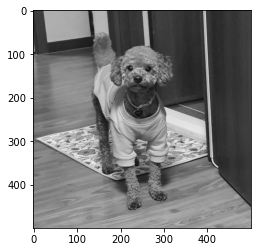

In [ ]:
plt.imshow(roi_img, cmap='gray')

## (2) Define functions

In [ ]:
def get_filters(size_array):
    '''
    Arguments
        size_array: List of filter size
    Usage:
        get_filters(3, 5, 7)
    '''
    filters = []
    for size in size_array:
        tmp_filter = np.ones((size, size))/size**2
        filters.append(tmp_filter.astype(float))
    return filters

In [ ]:
def avg_filter(roi, kernel, filter_type='custom'):
    
    kernel = kernel
    
    if filter_type=='custom':
        # this holds the end result
        filtered = np.zeros_like(roi)
        width = int((kernel.shape[1]-1)/2)
        height = int((kernel.shape[0]-1)/2)

        # do the filtering
        for i in range(height,roi.shape[1]-height):
            for j in range(width,roi.shape[0]-width):
                filtered[j,i]=np.sum(kernel*roi[j-width:j+width+1, i-height:i+height+1])
        return filtered
    
    else:
        filtered = cv2.filter2D(roi, -1, kernel)
        return filtered  

In [ ]:
filterset = [3, 5, 9, 15, 23]
filters = get_filters(filterset)

In [ ]:
def apply_filter(weights_list=None, roi=None, filter_type='custom', rep_time=20):
    '''
    Description:
        Apply filters, of custom or of open-cv, on roi(image) as much as given rep_time.
        
    Arguments:
        weights_list: List of weights(kernels) to use for filtering. Each element shall be of np.array type.
        roi         : Input image to apply filters.
        filter_type : If 'custom', uses custom-made filter. If 'cv', uses cv2.filter2D.
        rep_time    : Number of repetitions to be made per each weight(kernel).
    '''
    roi = roi.astype(float)
    
    # Saving results
    time_dict = {}
    filtered_imgs = []
    
    for weights in weights_list:
        print(f'Current kernel: {weights.shape}')
        time_per_weight = 0
        for rep in range(rep_time):
            time_s = time()
            
            # Filtering
            filtered_tmp = avg_filter(roi, weights, filter_type)
            
            # Time taken
            time_length = time() - time_s
            time_per_weight += time_length
        
        filtered_imgs.append(filtered_tmp)
        time_dict[str(weights.shape[0])] = time_per_weight/rep_time

    return filtered_imgs, time_dict

## (3) Apply filters on image

In [ ]:
result_cv, time_cv = apply_filter(weights_list=filters, roi=roi_img, filter_type='cv')

Current kernel: (3, 3)
Current kernel: (5, 5)
Current kernel: (9, 9)
Current kernel: (15, 15)
Current kernel: (23, 23)


In [ ]:
result_custom, time_custom = apply_filter(weights_list=filters, roi=roi_img, filter_type='custom')

Current kernel: (3, 3)
Current kernel: (5, 5)
Current kernel: (9, 9)
Current kernel: (15, 15)
Current kernel: (23, 23)


## (4) Evaluate the timing

Text(0.5, 1.0, 'custom kernel')

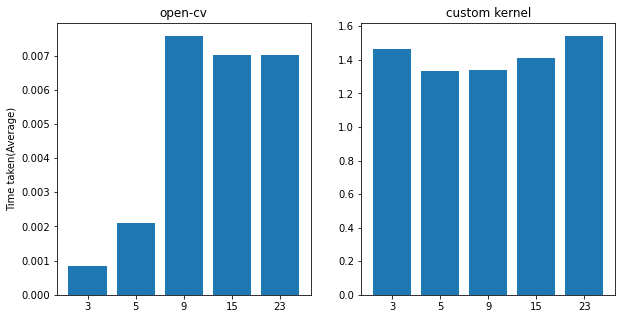

In [ ]:
# Comparing time taken using bar plots.
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

ax1.bar(time_cv.keys(), time_cv.values())
ax1.set_title("open-cv")
ax1.set_ylabel("Time taken(Average)")

ax2.bar(time_custom.keys(), time_custom.values())
ax2.set_title("custom kernel")

In [ ]:
# Comparing time taken using ratio between the two.
time_ratio = [list(time_custom.values())[i]/list(time_cv.values())[i] for i, _ in enumerate(time_cv)]
for i, key in enumerate(time_cv.keys()):
    print(f'[Kernel size: {key}]: Using CV is about {int(time_ratio[i])} times faster than using custom kernel.')

[Kernel size: 3]: Using CV is about 1759 times faster than using custom kernel.
[Kernel size: 5]: Using CV is about 635 times faster than using custom kernel.
[Kernel size: 9]: Using CV is about 176 times faster than using custom kernel.
[Kernel size: 15]: Using CV is about 201 times faster than using custom kernel.
[Kernel size: 23]: Using CV is about 219 times faster than using custom kernel.


## (5) Visualization

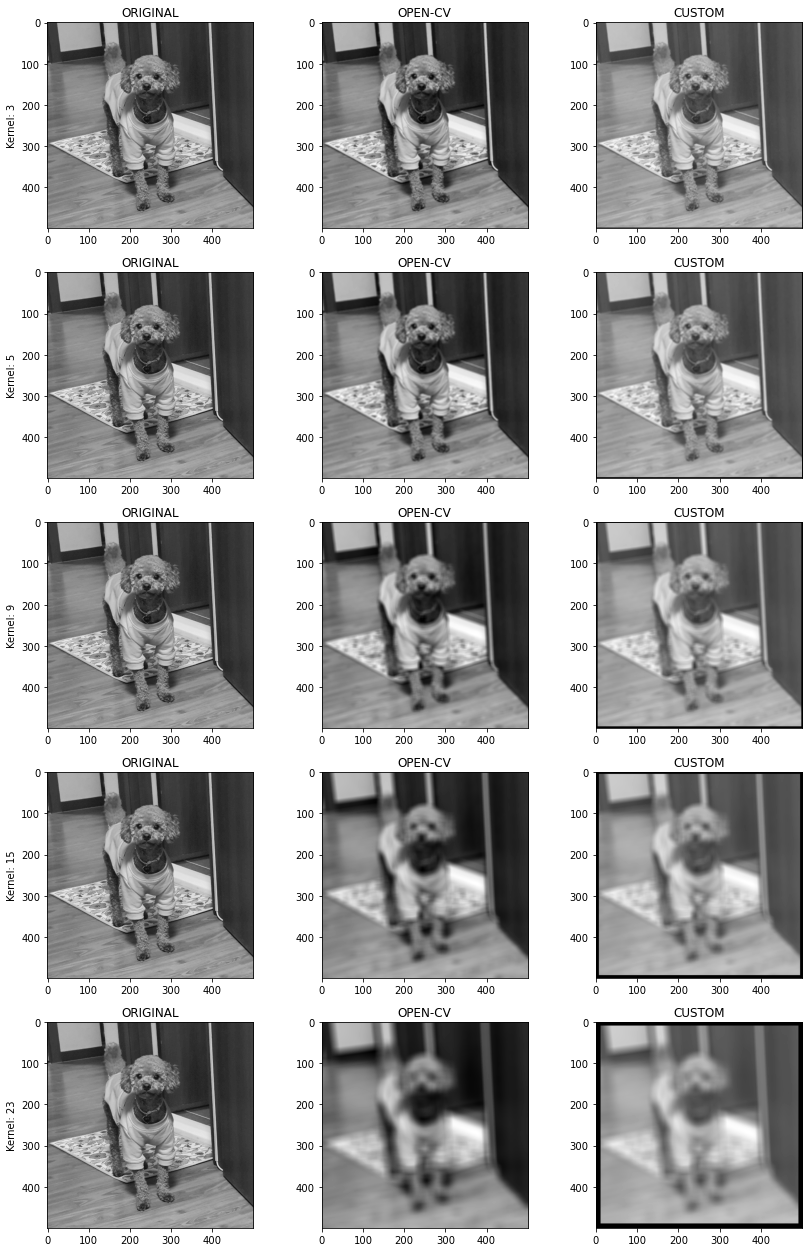

In [ ]:
# Plot every filtered images
nrows = len(filterset)
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3.5))

for r_i, r in enumerate(axes):
    for c_i, c in enumerate(r):
        if c_i == 0:
            c.imshow(roi_img, cmap='gray')
            c.set_title(f'ORIGINAL')
            c.set_ylabel(f'Kernel: {list(time_cv.keys())[r_i]}')
            
        if c_i == 1:
            c.imshow(result_cv[r_i], cmap='gray')
            c.set_title(f'OPEN-CV')
            
        elif c_i == 2:
            c.imshow(result_custom[r_i], cmap='gray')
            c.set_title(f'CUSTOM')
            
fig.tight_layout()

## (6) Discussion

### Common
The degree of blurriness along the kernel size is the same between using cv2.filter2D and using custom kernel.
As the kernel size gets increased, the more blurry the original image becomes. Larger kernels take more pixels into account during convolutions than smaller ones do, which result in the convolved pixels losing their clearance and getting more blurry.

### Different

1. Time taken<br>
Plots at part (4) indicate how much faster cv2.filter2D can work than custom made kernel.<br>
This is, as far as we've found out, mainly due to using "separable convolution" where a kernel is divided into vectors and constructed back into using outer-product.<br>
Source: https://blogs.mathworks.com/steve/2006/10/04/separable-convolution/

1. Padding<br>
Second difference to be identified is the black border around image, which occurs only when custom kernel is applied.<br>
This is due to a parameter of cv2.filter2D, 'borderType', which is set 'BORDER_REFLECT_101' by default. With such setting, it creates mirrored pixels around each side of an image so that it stays the same size after a kernel is applied.<br>
Not only the size being not changed, however, mirroring pixels also results in some unnatural distorts on its edges(much obvious when using kernel size=23). This is caused by cv2.filter2D filling in the zero valued blanks with the same pixels located on edges.<br>
The customized kernel, however, just lets the early created zero values(at the edges) stay as they are, which become the black borders shown above.

2. Brightness<br>
Another difference is that the images applied with custom kernel seems to be brighter than those applied with cv2.filter2D or the original image.<br>
This is due to the padding mentioned earlier. Zeroes around each image makes other center-located pixels' values get "relatively" huge, though the absolute values being the same as those of cv2.filter2D.<br>
For them to have the same brightness when plotted, we can simply cut out the zero valued edges so that the relative values of the pixels become normal. Below is the procedure to achive that. (Obviously, size of images gets smaller)

In [ ]:
# Cut out edges of zero values
result_custom_cut = [result_custom[i][s-1:-s+1, s-1:-s+1] for i, s in enumerate(filterset)]

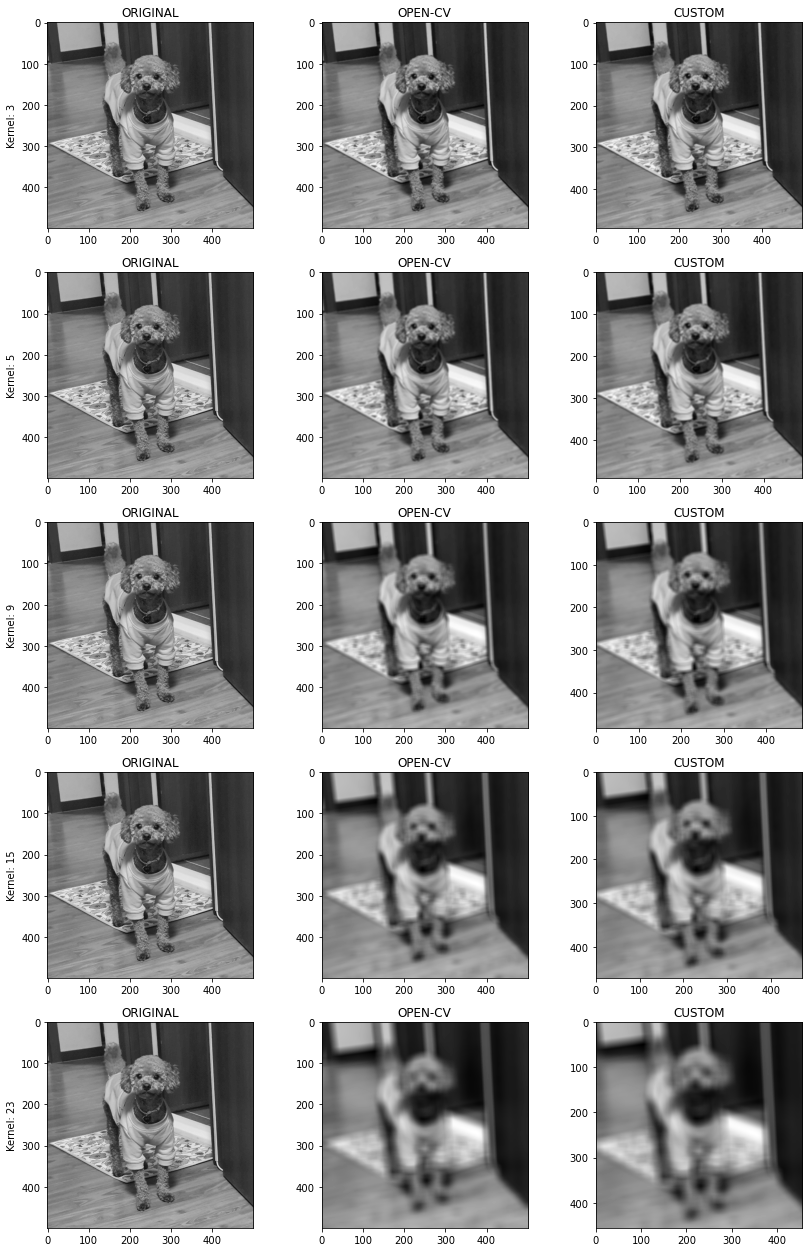

In [ ]:
# Plot every filtered images
nrows = len(filterset)
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3.5))

for r_i, r in enumerate(axes):
    for c_i, c in enumerate(r):
        if c_i == 0:
            c.imshow(roi_img, cmap='gray')
            c.set_title(f'ORIGINAL')
            c.set_ylabel(f'Kernel: {list(time_cv.keys())[r_i]}')
            
        if c_i == 1:
            c.imshow(result_cv[r_i], cmap='gray')
            c.set_title(f'OPEN-CV')
            
        elif c_i == 2:
            c.imshow(result_custom_cut[r_i], cmap='gray')
            c.set_title(f'CUSTOM')
            
fig.tight_layout()